In [139]:
import pandas as pd
# 订单读入
order = pd.read_csv('data/商品月订单训练集.csv')
order_test = pd.read_csv('data/商品月订单测试集.csv')
order

,product_id,type,year,month,order,start_stock,end_stock
0,1001,A1,2018,2,1129.0,47.0,70.0
1,1001,A1,2018,3,3568.0,70.0,91.0
2,1001,A1,2018,4,4560.0,91.0,110.0
3,1001,A1,2018,5,7521.0,110.0,47.0
4,1001,A1,2018,6,7687.0,47.0,41.0
...,...,...,...,...,...,...,...
7283,1210,A3,2020,8,14180.0,97.0,94.0
7284,1210,A3,2020,9,15034.0,94.0,79.0
7285,1210,A3,2020,10,14312.0,79.0,61.0
7286,1210,A3,2020,11,16180.0,81.0,88.0


In [140]:
# 需求读入，每天合并为月
demand = pd.read_csv('data/商品需求训练集.csv')
demand['date'] = pd.to_datetime(demand['date'])
demand['year'] = demand['date'].dt.year
demand['month'] = demand['date'].dt.month
demand=demand.groupby(['product_id', 'year', 'month']).agg({'is_sale_day':'mean', 'label':'sum'}).reset_index()

demand_test = pd.read_csv('data/商品需求测试集.csv')
demand_test['date'] = pd.to_datetime(demand_test['date'])
demand_test['year'] = demand_test['date'].dt.year
demand_test['month'] = demand_test['date'].dt.month
demand_test = demand_test.groupby(['product_id', 'year', 'month'])[['is_sale_day']].mean().reset_index()

demand

,product_id,year,month,is_sale_day,label
0,1001,2018,2,0.0,517.0
1,1001,2018,3,0.0,3190.0
2,1001,2018,4,0.0,4186.0
3,1001,2018,5,0.0,5412.0
4,1001,2018,6,0.0,5665.0
...,...,...,...,...,...
7283,1210,2020,8,1.0,6443.0
7284,1210,2020,9,1.0,6432.0
7285,1210,2020,10,1.0,5803.0
7286,1210,2020,11,1.0,6138.0


In [141]:
# 数据表合并
df = demand.merge(order, on=['product_id', 'year', 'month'], how='left')
df_test = demand_test.merge(order_test, on=['product_id', 'year', 'month'], how='left')
df

,product_id,year,month,is_sale_day,label,type,order,start_stock,end_stock
0,1001,2018,2,0.0,517.0,A1,1129.0,47.0,70.0
1,1001,2018,3,0.0,3190.0,A1,3568.0,70.0,91.0
2,1001,2018,4,0.0,4186.0,A1,4560.0,91.0,110.0
3,1001,2018,5,0.0,5412.0,A1,7521.0,110.0,47.0
4,1001,2018,6,0.0,5665.0,A1,7687.0,47.0,41.0
...,...,...,...,...,...,...,...,...,...
7283,1210,2020,8,1.0,6443.0,A3,14180.0,97.0,94.0
7284,1210,2020,9,1.0,6432.0,A3,15034.0,94.0,79.0
7285,1210,2020,10,1.0,5803.0,A3,14312.0,79.0,61.0
7286,1210,2020,11,1.0,6138.0,A3,16180.0,81.0,88.0


In [142]:
# 缺失值,缺失行label均为0
null_index = df.isnull().any(axis = 1) == True
df[null_index]['label'].sum()
df = df[~null_index]

In [143]:
df

,product_id,year,month,is_sale_day,label,type,order,start_stock,end_stock
0,1001,2018,2,0.0,517.0,A1,1129.0,47.0,70.0
1,1001,2018,3,0.0,3190.0,A1,3568.0,70.0,91.0
2,1001,2018,4,0.0,4186.0,A1,4560.0,91.0,110.0
3,1001,2018,5,0.0,5412.0,A1,7521.0,110.0,47.0
4,1001,2018,6,0.0,5665.0,A1,7687.0,47.0,41.0
...,...,...,...,...,...,...,...,...,...
7283,1210,2020,8,1.0,6443.0,A3,14180.0,97.0,94.0
7284,1210,2020,9,1.0,6432.0,A3,15034.0,94.0,79.0
7285,1210,2020,10,1.0,5803.0,A3,14312.0,79.0,61.0
7286,1210,2020,11,1.0,6138.0,A3,16180.0,81.0,88.0


In [144]:
import matplotlib.pyplot as plt
import os
import copy
# 训练数据集构建, 前八月加后三月（后三月中label置为0）预测后三月的
in_steps, out_steps = 8, 3
df = df.replace('A1', 1)
df = df.replace('A2', 2)
df = df.replace('A3', 3)
group_df = df.groupby('product_id')
norm_feat = ['label', 'order', 'start_stock', 'end_stock']
feat = ['month', 'type', 'is_sale_day', 'label', 'order', 'start_stock', 'end_stock']
if not os.path.exists('vis_png/'):
    os.makedirs('vis_png/')
ids, id_x_values, id_y_values = [], {}, {}
maxvalue, minvalue = {}, {}
group_df_value = {}
for key, value in group_df:
    group_df_value[key] = copy.deepcopy(value)
    maxvalue[key] = value[norm_feat].max()
    minvalue[key] = value[norm_feat].min()
    maxvalue[key]['start_stock'] = max(maxvalue[key]['start_stock'], maxvalue[key]['end_stock'])
    maxvalue[key]['end_stock'] = max(maxvalue[key]['start_stock'], maxvalue[key]['end_stock'])
    minvalue[key]['start_stock'] = min(minvalue[key]['start_stock'], minvalue[key]['end_stock'])
    minvalue[key]['end_stock'] = min(minvalue[key]['start_stock'], minvalue[key]['end_stock'])
    
    
    value[norm_feat] = (value[norm_feat]-value[norm_feat].min() + 1e-5) / (value[norm_feat].max() - value[norm_feat].min() + 1e-5)
    # plt.figure()
    # value['label'].plot(label='label')
    # value['order'].plot(label='order')
    # value['start_stock'].plot(label='start_stock')
    # value['end_stock'].plot(label='end_stock')
    # plt.legend()
    # plt.savefig(f'vis_png/{key}.png')
    id_xvalue, id_y_value = [], []
    for i in range(in_steps, len(value)-out_steps):
        if value['label'][i-8:i-4].values.tolist() == [0,0,0,0]:
            continue
        id_y_value.append(value['label'][i:i + 3].values.tolist())
        _data = value[feat][i-8:i+3].values
        _data[-3:, 3] = 0
        # print(_data)
        id_xvalue.append(_data.tolist())
    ids.append(key)
    id_x_values[key] = id_xvalue
    id_y_values[key] = id_y_value


In [145]:
group_df_value.keys()

dict_keys([1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166,

In [146]:
import numpy as np
# 测试集构建
df_test['label'] = [0]*len(df_test)
df_test = df_test.replace('A1', 1)
df_test = df_test.replace('A2', 2)
df_test = df_test.replace('A3', 3)
group_df_test = df_test.groupby('product_id')

test_ids_value, test_value = [], []
for key, value in group_df_test:
    value[norm_feat] = (value[norm_feat] - minvalue[key] + 1e-5) / (maxvalue[key] - minvalue[key] + 1e-5)
    value['label'] = 0
    group_df_value[key][norm_feat] = (group_df_value[key][norm_feat] - minvalue[key] + 1e-5) / (maxvalue[key] - minvalue[key] + 1e-5)
    
    _data1 = group_df_value[key][feat][-8:].values
    if _data1.max() > 12:
        print('data1', key, _data1.max())
    
    _data2 = value[feat].values
    if _data2.max() > 12:
        print('data2', key, _data2.max())
    
    # print(value_feat)
    _data = np.concatenate([_data1, _data2], axis=0)
    # print(_data)
    test_value.append(_data.tolist())
    test_ids_value.append(key)


In [147]:
maxvalue[1117], minvalue[1117]

(label              0.0
 order          17381.0
 start_stock      117.0
 end_stock        117.0
 dtype: float64,
 label             0.0
 order          1101.0
 start_stock      40.0
 end_stock        40.0
 dtype: float64)

In [148]:
for key, value in group_df_test:
    if key == 1117:
        print(value[norm_feat])
        value_feat = (value[norm_feat] - minvalue[key] + 1e-5) / (maxvalue[key] - minvalue[key] + 1e-5)
        value_feat['label'] = 0
        train_value = (group_df_value[key][norm_feat] - minvalue[key] + 1e-5) / (maxvalue[key] - minvalue[key] + 1e-5)
        print(value_feat)
        print(train_value)
        break

     label    order  start_stock  end_stock
348      0  15182.0         55.0       71.0
349      0   1128.0         71.0       82.0
350      0  10756.0         82.0       66.0
     label     order  start_stock  end_stock
348      0  0.864926     0.194805   0.402597
349      0  0.001658     0.402597   0.545455
350      0  0.593059     0.545455   0.337662
         label     order  start_stock  end_stock
4060  100001.0 -0.067629     -0.51948  -0.519480
4061  100001.0 -0.067620     -0.51948  -0.519480
4062  100001.0 -0.067616     -0.51948  -0.519480
4063  100001.0 -0.067605     -0.51948  -0.519480
4064  100001.0 -0.067604     -0.51948  -0.519480
4065  100001.0 -0.067600     -0.51948  -0.519480
4066  100001.0 -0.067602     -0.51948  -0.519480
4067  100001.0 -0.067603     -0.51948  -0.519480
4068  100001.0 -0.067605     -0.51948  -0.519480
4069  100001.0 -0.067601     -0.51948  -0.519480
4070  100001.0 -0.067598     -0.51948  -0.519480
4071  100001.0 -0.067607     -0.51948  -0.519480
4072  1

In [149]:
np.array(test_value).shape, len(test_ids_value), len(group_df_test)

((209, 11, 7), 209, 209)

In [150]:
# 训练测试划分
import random
n_split = 5
random.shuffle(ids)
x_train, y_train = {}, {}
x_test, y_test = {}, {}
ids_map = []
for tmpi, i in enumerate(range(0, len(ids), len(ids)//5)):
    test_ids = ids[i:i+len(ids)//5]
    train_ids = list(set(ids) - set(test_ids))
    ids_map.append([train_ids, test_ids])

    x_train[tmpi] = []
    y_train[tmpi] = []
    
    list(map(lambda x: x_train[tmpi].extend(id_x_values[x]), train_ids))
    list(map(lambda x: y_train[tmpi].extend(id_y_values[x]), train_ids))
    x_test[tmpi] = []
    y_test[tmpi] = []
    list(map(lambda x: x_test[tmpi].extend(id_x_values[x]), test_ids))
    list(map(lambda x: y_test[tmpi].extend(id_y_values[x]), test_ids))

In [151]:
import numpy as np
np.array(x_train[0]).shape

(3902, 11, 7)

In [152]:
from torch import nn
import torch

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # 单向LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first = True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq):
        # batch_size, seq_len = input_seq[0], input_seq[1]
        # 两个初始化
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(device)
        # output(batch_size, seq_len, num_directions * hidden_size)
        #前向计算
        output, _ = self.lstm(input_seq, (h_0, c_0))
        pred = self.linear(output)
        pred = pred[:, -1, :]
        return pred

In [153]:
# 重复五折交叉熵，0-4
random_split = 4

In [154]:
from tqdm import tqdm
from torch.utils.data import DataLoader,TensorDataset
from torch.optim.lr_scheduler import StepLR
import copy 

device = 'cuda'
batch_size = 512
test_loader = DataLoader(TensorDataset(torch.tensor(x_test[random_split]).float(), torch.tensor(y_test[random_split]).float()), batch_size, True, drop_last=True, pin_memory = True)
    
def get_val_loss(model):
    model.eval()
    loss_function = nn.MSELoss().to(device)
    val_loss = []
    for (seq, label) in test_loader:
        with torch.no_grad():
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            val_loss.append(loss.item())

    return np.mean(val_loss)

def train(path):
    input_size, hidden_size, num_layers = 7, 32, 2
    output_size = 3
    # 定义模型优化器、损失函数等
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size = batch_size).to(device)
    train_loader = DataLoader(TensorDataset(torch.tensor(x_train[random_split]).float(), torch.tensor(y_train[random_split]).float()), batch_size, True, drop_last=True, pin_memory = True)
    loss_function = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=500, gamma=0.1)
    # training
    min_epochs = 10
    best_model = None
    min_val_loss = 5
    pbar = tqdm(range(1000))
    for epoch in pbar:
        train_loss = []
        for seq, label in train_loader:
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            train_loss.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        scheduler.step()
        # validation
        val_loss = get_val_loss(model)
        if epoch > min_epochs and val_loss < min_val_loss:
            min_val_loss = val_loss
            best_model = copy.deepcopy(model)

        pbar.set_description('epoch {:03d} train_loss {:.8f} test_loss {:.8f}'.format(epoch, np.mean(train_loss), val_loss))
        model.train()

    state = {'models': best_model.state_dict()}
    torch.save(state, path)

train(f'train{random_split}')

epoch 999 train_loss 0.00980012 test_loss 0.01157164: 100%|██████████| 1000/1000 [01:28<00:00, 11.26it/s]


loading models...
predicting...


100%|██████████| 1/1 [00:00<00:00, 83.36it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


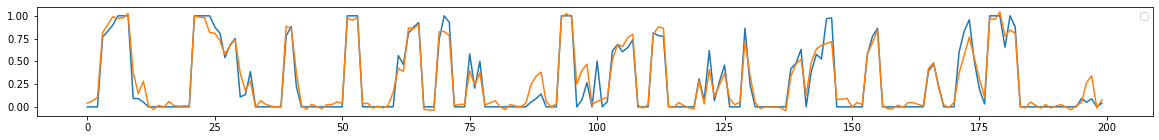

In [155]:
from itertools import chain
from scipy.interpolate import make_interp_spline
device = 'cuda'
def test(path):
    pred = []
    y = []
    print('loading models...')
    input_size, hidden_size, num_layers = 7, 32, 2
    output_size = 3
    test_loader = DataLoader(TensorDataset(torch.tensor(x_test[random_split]).float(),torch.tensor(y_test[random_split]).float()), batch_size, True, drop_last = True, pin_memory = True)
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=batch_size).to(device)
    model.load_state_dict(torch.load(path)['models'])
    model.eval()
    print('predicting...')
    for (seq, target) in tqdm(test_loader):
        # print(target)
        target = list(chain.from_iterable(target))
        y.extend(target)
        seq = seq.to(device)
        with torch.no_grad():
            y_pred = model(seq)
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))
            pred.extend(y_pred)

    y, pred = np.array(y), np.array(pred)
    plt.figure(figsize=(20, 2))
    plt.plot(y[:200])
    plt.plot(pred[:200])
    
    plt.legend()
    # plt.show()
    plt.savefig(f'cv{random_split}.png')
test(f'train{random_split}')

In [156]:
len(test_ids_value), len(test_value)

(209, 209)

In [157]:
from itertools import chain
from scipy.interpolate import make_interp_spline
device = 'cuda'
def predict(path):
    pred = []
    y = []
    input_size, hidden_size, num_layers = 7, 32, 2
    output_size = 3
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=1).to(device)
    model.load_state_dict(torch.load(path)['models'])
    model.eval()
    print('predicting...')
    test_res = pd.DataFrame(columns=['product_id', 'month', 'label'])
    sidx = 0
    for map_id, seq in zip(test_ids_value, test_value):
        if map_id == 1165:
            print(seq)
        seq = torch.Tensor(np.array(seq)[np.newaxis,:,:]).to(device)
        # print(seq.size())
        with torch.no_grad():
            y_pred = model(seq)
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))
            tmp = list(map(lambda x: x*(maxvalue[map_id]['label']-minvalue[map_id]['label'])+minvalue[map_id]['label'], y_pred))
            tmp = list(map(lambda x: x if x>0 else 0, tmp))
            for _m in range(3):
                test_res.loc[sidx] = [map_id, _m+1, tmp[_m]]
                sidx += 1
    
    return test_res

res = predict(f'train{random_split}')

predicting...
[[5.0, 2.0, 1.0, 0.724021006606285, 0.6984643736495919, 0.3273195962974279, 0.21520619568033253], [6.0, 2.0, 1.0, 0.7442004715113094, 0.7346437348067298, 0.21520619568033253, 0.4935567075572589], [7.0, 2.0, 1.0, 0.8391431998349489, 0.9050368550951862, 0.4252577393652353, 0.3569587711732117], [8.0, 2.0, 1.0, 0.8073440020645313, 0.8033783784991533, 0.3569587711732117, 0.21391753590312454], [9.0, 2.0, 1.0, 0.7002439731628648, 0.8558353809239341, 0.21391753590312454, 0.25902062810540427], [10.0, 2.0, 1.0, 0.7034280280761576, 0.8114864866022811, 0.25902062810540427, 0.31443299852534795], [11.0, 2.0, 1.0, 0.6662531531794016, 0.9262285012738154, 0.28221650409514815, 0.14948454704272493], [12.0, 2.0, 1.0, 0.7119050573907683, 1.0, 0.14948454704272493, 0.13917526882506098], [1.0, 2.0, 1.0, 0.0, 0.864926290009259, 0.13917526882506098, 0.19716495879942064], [2.0, 2.0, 1.0, 0.0, 0.0016584772717085521, 0.19716495879942064, 0.4046391829299074], [3.0, 2.0, 1.0, 0.0, 0.5930589683089318, 0

In [158]:
res

,product_id,month,label
0,1001.0,1.0,1801.888640
1,1001.0,2.0,340.709395
2,1001.0,3.0,2724.021767
3,1002.0,1.0,5326.202523
4,1002.0,2.0,1665.749244
...,...,...,...
622,1209.0,2.0,440.095637
623,1209.0,3.0,1657.637267
624,1210.0,1.0,3501.937541
625,1210.0,2.0,992.637799


In [159]:
res = res.sort_values(by=['month', 'product_id'])
sub = pd.read_csv(os.path.join('data/提交示例.csv'))
sub['label'] = res['label'].values
sub['label'] = sub['label'].map(lambda x: x if x >= 0 else 0)

sub.to_csv(f'baseline_L_cv{random_split}.csv', index = False)

In [160]:
ids_map[3][1]

[1040,
 1128,
 1052,
 1150,
 1045,
 1196,
 1174,
 1016,
 1202,
 1195,
 1101,
 1184,
 1063,
 1038,
 1097,
 1034,
 1014,
 1073,
 1080,
 1083,
 1172,
 1062,
 1114,
 1168,
 1133,
 1185,
 1148,
 1156,
 1026,
 1012,
 1004,
 1161,
 1179,
 1006,
 1055,
 1057,
 1203,
 1017,
 1076,
 1193,
 1036]

In [161]:
pred0 = pd.read_csv('baseline_L_cv0.csv')
pred1 = pd.read_csv('baseline_L_cv1.csv')
pred2 = pd.read_csv('baseline_L_cv2.csv')
pred3 = pd.read_csv('baseline_L_cv3.csv')
pred4 = pd.read_csv('baseline_L_cv4.csv')
pred = copy.deepcopy(pred0)
pred['label'] = (pred0['label'] + pred1['label'] + pred2['label'] + pred3['label'] + pred4['label']) / 5
pred.to_csv(f'baseline_L_cv.csv', index = False)